In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import collections
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE 
from sklearn import svm
import numpy as np

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
train_data = pd.read_csv('./drive/My Drive/BT4240 data/result.csv')\
              .drop(columns=['Unnamed: 0', 'Unnamed: 0.1'],axis=1)
train_data.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.00,Supplies,My students need matching shirts to wear for d...
1,p063374,403c6783e9286e51ab318fba40f8d729,Mrs.,DE,2016-11-05 10:01:51,Grades PreK-2,"Applied Learning, Literacy & Language","Character Education, Literature & Writing",Need to Reach Our Virtual Mentors!!!,My kids tell me each day that they want to mak...,I started a program called Telementoring in ho...,NaN,NaN,My students need tablets in order to communic...,0,1,{Amazon - Fire Kids Edition - 7'- Tablet - 16G...,727.36,Technology,My students need tablets in order to communic...
2,p114989,b580c11b1497a0a67317763b7f03eb27,Ms.,IN,2016-09-13 22:35:57,Grades 6-8,Math & Science,Mathematics,Wobble Chairs Help Fidgety Kids Focus,My seventh graders dream big. They can't wait ...,I have used alternative seating in my classroo...,NaN,NaN,My students need seating that allows the most ...,13,1,"{Kore Patented WOBBLE Chair, Made in the USA, ...",319.80,Supplies,My students need seating that allows the most ...


## Feature Selection

In [4]:
train_data.shape

(121308, 20)

In [5]:
train_data['project_subject_categories'] = train_data['project_subject_categories'].str.split(", ").to_frame()
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].str.split(", ").to_frame()
train_data['Project Resource Category'] = train_data['Project Resource Category'].str.split(", ").to_frame()

train_data.head(1)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"[Music & The Arts, Health & Sports]","[Performing Arts, Team Sports]",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.0,[Supplies],My students need matching shirts to wear for d...


In [6]:
train_data['project_subject_categories'] = train_data['project_subject_categories'].apply(collections.Counter)
train_data['project_subject_subcategories'] = train_data['project_subject_subcategories'].apply(collections.Counter)
train_data['Project Resource Category'] = train_data['Project Resource Category'].apply(collections.Counter)

project_subject_categories = pd.DataFrame.from_records(train_data['project_subject_categories']).fillna(value=0).add_prefix("proj_cat_")
project_subject_subcategories = pd.DataFrame.from_records(train_data['project_subject_subcategories']).fillna(value=0).add_prefix("proj_sub_cat_")
Project_Resource_Category = pd.DataFrame.from_records(train_data['Project Resource Category']).fillna(value=0).add_prefix("res_cat_")

train_data = pd.concat([train_data, project_subject_categories], axis=1)
train_data = pd.concat([train_data, project_subject_subcategories], axis=1)
train_data = pd.concat([train_data, Project_Resource_Category], axis=1)

train_data.head(1)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,total_cost,Project Resource Category,Project Need Statement,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,proj_cat_Warmth,proj_cat_Care & Hunger,proj_sub_cat_Performing Arts,proj_sub_cat_Team Sports,proj_sub_cat_Character Education,proj_sub_cat_Literature & Writing,proj_sub_cat_Mathematics,proj_sub_cat_Literacy,proj_sub_cat_Special Needs,proj_sub_cat_Early Development,proj_sub_cat_Environmental Science,proj_sub_cat_Health & Wellness,proj_sub_cat_Music,proj_sub_cat_Applied Sciences,proj_sub_cat_Visual Arts,proj_sub_cat_ESL,proj_sub_cat_Extracurricular,proj_sub_cat_Gym & Fitness,proj_sub_cat_History & Geography,proj_sub_cat_College & Career Prep,proj_sub_cat_Health & Life Science,proj_sub_cat_Other,proj_sub_cat_Warmth,proj_sub_cat_Care & Hunger,proj_sub_cat_Social Sciences,proj_sub_cat_Foreign Languages,proj_sub_cat_Parent Involvement,proj_sub_cat_Nutrition Education,proj_sub_cat_Civics & Government,proj_sub_cat_Community Service,proj_sub_cat_Financial Literacy,proj_sub_cat_Economics,res_cat_Supplies,res_cat_Technology,res_cat_Books,res_cat_Other,res_cat_Computers & Tablets,res_cat_Food,res_cat_Clothing & Hygiene,res_cat_Flexible Seating,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"{'Music & The Arts': 1, 'Health & Sports': 1}","{'Performing Arts': 1, 'Team Sports': 1}",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,{Reebok Girls' Fashion Dance Graphic T-Shirt -...,400.0,{'Supplies': 1},My students need matching shirts to wear for d...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_data.plot

In [8]:
#assert(len(train_data.columns))==len(set(train_data.columns))
!pip install iteration_utilities
from iteration_utilities import duplicates

In [9]:
train_data = train_data.loc[:,~train_data.columns.duplicated()]
train_data = train_data.drop(columns = ['proj_sub_cat_Care & Hunger', 'proj_sub_cat_Special Needs', 'proj_sub_cat_Warmth'])
len(train_data.columns)

74

In [10]:
train_df = train_data.select_dtypes(exclude=['object','category'])
print(len(train_df.columns))
print(train_df.dtypes.unique())
cat_columns = [col for col in train_df.columns if 'cat' in col]
train_df.head(1)

57
[dtype('int64') dtype('float64')]


,teacher_number_of_previously_posted_projects,project_is_approved,total_cost,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,proj_cat_Warmth,proj_cat_Care & Hunger,proj_sub_cat_Performing Arts,proj_sub_cat_Team Sports,proj_sub_cat_Character Education,proj_sub_cat_Literature & Writing,proj_sub_cat_Mathematics,proj_sub_cat_Literacy,proj_sub_cat_Early Development,proj_sub_cat_Environmental Science,proj_sub_cat_Health & Wellness,proj_sub_cat_Music,proj_sub_cat_Applied Sciences,proj_sub_cat_Visual Arts,proj_sub_cat_ESL,proj_sub_cat_Extracurricular,proj_sub_cat_Gym & Fitness,proj_sub_cat_History & Geography,proj_sub_cat_College & Career Prep,proj_sub_cat_Health & Life Science,proj_sub_cat_Other,proj_sub_cat_Social Sciences,proj_sub_cat_Foreign Languages,proj_sub_cat_Parent Involvement,proj_sub_cat_Nutrition Education,proj_sub_cat_Civics & Government,proj_sub_cat_Community Service,proj_sub_cat_Financial Literacy,proj_sub_cat_Economics,res_cat_Supplies,res_cat_Technology,res_cat_Books,res_cat_Other,res_cat_Computers & Tablets,res_cat_Food,res_cat_Clothing & Hygiene,res_cat_Flexible Seating,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,1,0,400.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
train_df[cat_columns] = train_df[cat_columns].astype('int8')
train_df.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,teacher_number_of_previously_posted_projects,project_is_approved,total_cost,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,proj_cat_Warmth,proj_cat_Care & Hunger,proj_sub_cat_Performing Arts,proj_sub_cat_Team Sports,proj_sub_cat_Character Education,proj_sub_cat_Literature & Writing,proj_sub_cat_Mathematics,proj_sub_cat_Literacy,proj_sub_cat_Early Development,proj_sub_cat_Environmental Science,proj_sub_cat_Health & Wellness,proj_sub_cat_Music,proj_sub_cat_Applied Sciences,proj_sub_cat_Visual Arts,proj_sub_cat_ESL,proj_sub_cat_Extracurricular,proj_sub_cat_Gym & Fitness,proj_sub_cat_History & Geography,proj_sub_cat_College & Career Prep,proj_sub_cat_Health & Life Science,proj_sub_cat_Other,proj_sub_cat_Social Sciences,proj_sub_cat_Foreign Languages,proj_sub_cat_Parent Involvement,proj_sub_cat_Nutrition Education,proj_sub_cat_Civics & Government,proj_sub_cat_Community Service,proj_sub_cat_Financial Literacy,proj_sub_cat_Economics,res_cat_Supplies,res_cat_Technology,res_cat_Books,res_cat_Other,res_cat_Computers & Tablets,res_cat_Food,res_cat_Clothing & Hygiene,res_cat_Flexible Seating,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
0,1,0,400.00,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,727.36,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,1,319.80,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
X = train_df.loc[:, train_df.columns != 'project_is_approved']
y = train_df.loc[:, train_df.columns == 'project_is_approved']
print(X.shape)
print(y.shape)

print(type(y))
print("Number of features: {}".format(len(X.columns)))

(121308, 56)
(121308, 1)
<class 'pandas.core.frame.DataFrame'>
Number of features: 56


### Normalize numerical features

In [13]:
# standardize numeric features: teacher_number_of_previously_posted_projects, total_cost
scaler = preprocessing.MinMaxScaler()
stand_cols = ['teacher_number_of_previously_posted_projects', 'total_cost']
for col_name in stand_cols:
    X[col_name] = scaler.fit_transform(X[col_name].values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Create train, test, and validation sets

Train: (72784, 56), Val:(24262, 56) ,Test: (24262, 56)


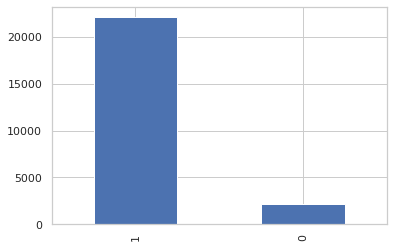

In [14]:
# split X, Y to train, valid and test by 6:2:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

train_breakdown_out = y_train['project_is_approved']
test_breakdown_out = y_test['project_is_approved']
pd.value_counts(test_breakdown_out).plot.bar()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print("Train: {}, Val:{} ,Test: {}".format(X_train.shape, X_val.shape, X_test.shape))

In [0]:
#train_breakdown = y_train['project_is_approved'].value_counts()
#val_breakdown = y_val['project_is_approved'].value_counts()

#print("Training Set")
#print(train_breakdown)
#print(" ")
#print("Validation Set")
#print(val_breakdown)



In [0]:
train_breakdown_out = y_train['project_is_approved']
#val_breakdown_out = y_val['project_is_approved'] 
test_breakdown_out = y_test['project_is_approved']

#pd.value_counts(train_breakdown_out).plot.bar()
#pd.value_counts(val_breakdown_out).plot.bar()
#pd.value_counts(test_breakdown_out).plot.bar()

## SMOTE Sampling

In [15]:
X_train.describe(include='all')

,teacher_number_of_previously_posted_projects,total_cost,proj_cat_Music & The Arts,proj_cat_Health & Sports,proj_cat_Applied Learning,proj_cat_Literacy & Language,proj_cat_Math & Science,proj_cat_Special Needs,proj_cat_History & Civics,proj_cat_Warmth,proj_cat_Care & Hunger,proj_sub_cat_Performing Arts,proj_sub_cat_Team Sports,proj_sub_cat_Character Education,proj_sub_cat_Literature & Writing,proj_sub_cat_Mathematics,proj_sub_cat_Literacy,proj_sub_cat_Early Development,proj_sub_cat_Environmental Science,proj_sub_cat_Health & Wellness,proj_sub_cat_Music,proj_sub_cat_Applied Sciences,proj_sub_cat_Visual Arts,proj_sub_cat_ESL,proj_sub_cat_Extracurricular,proj_sub_cat_Gym & Fitness,proj_sub_cat_History & Geography,proj_sub_cat_College & Career Prep,proj_sub_cat_Health & Life Science,proj_sub_cat_Other,proj_sub_cat_Social Sciences,proj_sub_cat_Foreign Languages,proj_sub_cat_Parent Involvement,proj_sub_cat_Nutrition Education,proj_sub_cat_Civics & Government,proj_sub_cat_Community Service,proj_sub_cat_Financial Literacy,proj_sub_cat_Economics,res_cat_Supplies,res_cat_Technology,res_cat_Books,res_cat_Other,res_cat_Computers & Tablets,res_cat_Food,res_cat_Clothing & Hygiene,res_cat_Flexible Seating,res_cat_Reading Nooks,res_cat_Desks & Storage,res_cat_Instructional Technology,res_cat_Classroom Basics,res_cat_Educational Kits & Games,res_cat_Sports & Exercise Equipment,res_cat_Musical Instruments,res_cat_Art Supplies,res_cat_Lab Equipment,res_cat_Visitors
count,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000,72784.000000
mean,0.024485,0.032552,0.084236,0.101039,0.100846,0.530955,0.431413,0.110450,0.048294,0.013492,0.013492,0.015951,0.015993,0.014948,0.235189,0.315083,0.336928,0.035145,0.051564,0.072324,0.026695,0.089621,0.050354,0.039981,0.006457,0.032480,0.027451,0.026531,0.038621,0.017504,0.014852,0.007117,0.005427,0.008848,0.007502,0.002830,0.004781,0.001800,0.444892,0.397766,0.123956,0.006087,0.024305,0.000412,0.000412,0.000824,0.000522,0.000522,0.000618,0.000179,0.000055,0.000069,0.000069,0.000110,0.000110,0.000027
std,0.059818,0.039045,0.277743,0.301382,0.301127,0.499044,0.495277,0.313452,0.214387,0.115370,0.115370,0.125288,0.125447,0.121347,0.424120,0.464552,0.472663,0.184148,0.221146,0.259025,0.161193,0.285640,0.218677,0.195917,0.080099,0.177271,0.163395,0.160708,0.192692,0.131140,0.120962,0.084062,0.073469,0.093648,0.086287,0.053126,0.068982,0.042387,0.496957,0.489440,0.329533,0.077779,0.153995,0.020298,0.020298,0.028700,0.022844,0.022844,0.024857,0.013363,0.007413,0.008288,0.008288,0.010483,0.010483,0.005242
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.010887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [16]:
# use SMOTE with only the train set
os = SMOTE(random_state=1)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['project_is_approved'])

# we can check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not approved in oversampled data",len(os_data_y[os_data_y['project_is_approved']==0]))
print("Number of approved in oversampled data",len(os_data_y[os_data_y['project_is_approved']==1]))
print("Proportion of not approved data in oversampled data is ",len(os_data_y[os_data_y['project_is_approved']==0])/len(os_data_X))
print("Proportion of approved data in oversampled data is ",len(os_data_y[os_data_y['project_is_approved']==1])/len(os_data_X))
print(os_data_X.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  132432
Number of not approved in oversampled data 66216
Number of approved in oversampled data 66216
Proportion of not approved data in oversampled data is  0.5
Proportion of approved data in oversampled data is  0.5
(132432, 56)


## Building model

In [17]:
os_data_X[os_data_X.columns[~os_data_X.columns.isin(stand_cols)]] = os_data_X[os_data_X.columns[~os_data_X.columns.isin(stand_cols)]].astype('int')
os_data_X.shape

(132432, 56)

### Model Fit 1

In [0]:
from sklearn.metrics import roc_curve, auc

In [0]:
half_val = int(24262/2)
X_val_half = X_val[0:half_val]
y_val_half = y_val[0:half_val]
classifier = svm.SVC(kernel='linear',probability=True , C = 0.1)
classifier.fit(os_data_X, os_data_y)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
y_pred = classifier.predict(X_val_half)

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(y_val_half, y_pred)

In [0]:
# Plot ROC curve
ptl.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiverrating characteristic example')
plt.legend(loc="lower right")
plt.show()


SVM Confusion Matrix

array([[ 1436,   764],
       [ 9532, 12530]])

In [0]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Feature Reduction: First Attempt

In [0]:
est = sm.Logit(os_data_y, os_data_X)
est2 = est.fit()
print(est2.summary())

In [0]:
p_value_list = [est2.pvalues[i] for i in range(56)]
significant_level = 0.1
p_value_bool = [p_value_list[i] < significant_level for i in range(56)]
num_true = sum(p_value_bool)
print("The number of significant features: {}".format(num_true))

In [0]:
### Model Fit 2

In [0]:
assert(len(p_value_bool)==os_data_X.shape[1])
model2_col = os_data_X.columns[p_value_bool]
print(model2_col)
print(len(model2_col))
os_data_X2 = os_data_X[model2_col]

In [0]:
logreg2 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
logreg2.fit(os_data_X2, os_data_y)
X_train2 = X_train[model2_col]
X_val2 = X_val[model2_col]
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg2.score(X_train2, y_train)))
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(logreg2.score(X_val2, y_val)))

In [0]:
est_model2 = sm.Logit(os_data_y, os_data_X2)
est2_model2 = est_model2.fit()
print(est2_model2.summary())

### Confusion Matrix

In [0]:
y_val_pred = logreg2.predict(X_val2)
confusion_matrix = metrics.confusion_matrix(y_val, y_val_pred)
confusion_matrix

### ROC Curve

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, logreg2.predict_proba(X_val2)[:,1])
roc_auc = metrics.roc_auc_score(y_val, logreg2.predict(X_val2))

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")